In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
%%time
# Import the dataset with Pre-processed Reviews
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')
data = pd.concat([data_train, data_test], ignore_index=True)

del data_train, data_test

Wall time: 1.31 s


In [3]:
%%time
# Vectorize the Reviews using TFIDF Vectorizer
tfidf_model = TfidfVectorizer(max_features=15000, min_df=5)
vectors = tfidf_model.fit_transform(data['CleanedText'].values)
print(vectors.shape)

(80000, 10914)
Wall time: 3.58 s


In [4]:
%%time
# Evaluate and store the top 3000 TFIDF Vectors and their corresponding words
indices = np.argsort(tfidf_model.idf_)[::-1]
features = tfidf_model.get_feature_names()
top_n = 3000
top_feats = [features[i] for i in indices[:top_n]]
top_idf = [tfidf_model.idf_[i] for i in indices[:top_n]]

print(list(zip(top_feats, top_idf)))

[('ironi', 10.49803494434984), ('luau', 10.49803494434984), ('lucious', 10.49803494434984), ('sprig', 10.49803494434984), ('springi', 10.49803494434984), ('tabbouleh', 10.49803494434984), ('sprint', 10.49803494434984), ('panini', 10.49803494434984), ('bionatur', 10.49803494434984), ('discret', 10.49803494434984), ('usb', 10.49803494434984), ('toothi', 10.49803494434984), ('disconcert', 10.49803494434984), ('bismol', 10.49803494434984), ('resend', 10.49803494434984), ('iren', 10.49803494434984), ('spruce', 10.49803494434984), ('keenan', 10.49803494434984), ('carolyn', 10.49803494434984), ('plasma', 10.49803494434984), ('uranium', 10.49803494434984), ('paperi', 10.49803494434984), ('uptak', 10.49803494434984), ('pappi', 10.49803494434984), ('lovabl', 10.49803494434984), ('lov', 10.49803494434984), ('biz', 10.49803494434984), ('idahoan', 10.49803494434984), ('disgruntl', 10.49803494434984), ('dishearten', 10.49803494434984), ('resal', 10.49803494434984), ('spork', 10.49803494434984), ('im

In [5]:
%%time
# Evaluate the Co-occurence matrix with context window '5'
def get_co_occur_matrix(data, vocab, context_window=5):
    a = pd.DataFrame(np.zeros((len(vocab), len(vocab))), index=vocab, columns=vocab)
    for review in data['CleanedText']:
        words = review.split()
        for idx in range(len(words)):
            if a.get(words[idx]) is None:
                continue
            for i in range(1, context_window+1):
                if idx-i >= 0:
                    if a.get(words[idx-i]) is not None:
                        a[words[idx-i]].loc[words[idx]] = a.get(words[idx-i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx-i]] = a.get(words[idx]).loc[words[idx-i]] + 1
                if idx+i < len(words):
                    if a.get(words[idx+i]) is not None:
                        a[words[idx+i]].loc[words[idx]] = a.get(words[idx+i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx+i]] = a.get(words[idx]).loc[words[idx+i]] + 1
    np.fill_diagonal(a.values, 0)
    return a

co_matrix = get_co_occur_matrix(data, top_feats)

Wall time: 37.7 s


In [6]:
%%time
# Display 20 samples in Co-occurence matrix
counter = 0
for i in co_matrix.index:
    if counter == 20:
        break
    for j in co_matrix.index:
        if co_matrix.loc[j][i] != 0:
            print (i,j,"===>", co_matrix.loc[j][i])
            counter += 1

ironi victori ===> 2.0
luau mack ===> 2.0
sprig passionfruit ===> 2.0
tabbouleh kalamata ===> 2.0
panini provolon ===> 2.0
panini untoast ===> 2.0
usb gizmo ===> 2.0
usb mic ===> 8.0
usb icicl ===> 2.0
usb cord ===> 2.0
toothi fusilli ===> 2.0
resend undo ===> 2.0
iren maria ===> 2.0
carolyn cellular ===> 2.0
carolyn margaret ===> 4.0
plasma peroxid ===> 2.0
plasma doom ===> 2.0
pappi sissi ===> 4.0
lovabl goofi ===> 2.0
biz headlin ===> 2.0
Wall time: 8.92 s


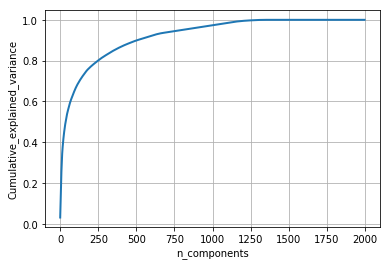

Wall time: 17.1 s


In [7]:
%%time
# Dim-reduction using Truncated SVD and get the Top Singular Values explaining the most variance
svd = TruncatedSVD(n_components=1999, random_state=42)
svd_matrix = svd.fit_transform(co_matrix)
cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the Truncated SVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [8]:
%%time
# Get the minimum components with max explained variance
for i in range(len(cum_var_explained)):
    if cum_var_explained[i] >= 1.0:
        print(i)
        break

1357
Wall time: 0 ns


In [9]:
%%time
# Dim-Reduction using optimal components
svd = TruncatedSVD(n_components=1357, random_state=42)
svd_matrix = svd.fit_transform(co_matrix)
print(svd_matrix.shape)

(3000, 1357)
Wall time: 9.16 s


Starting Cluster #2
Starting Cluster #4
Starting Cluster #5
Starting Cluster #7
Starting Cluster #8
Starting Cluster #10


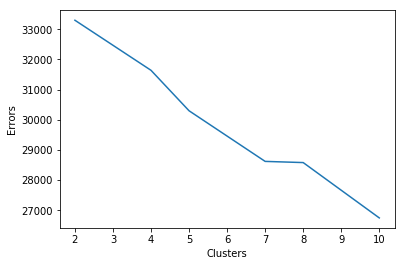

Wall time: 9.98 s


In [10]:
%%time
# Clusterize the dataset using K-Means Clustering and get the optimal Cluster number
# sc = StandardScaler()
# svd_scaled = sc.fit_transform(svd_matrix)

errors = []; clusters = [2, 4, 5, 7, 8, 10];
for i in clusters:
    print(f'Starting Cluster #{i}')
    model = KMeans(n_clusters=i, random_state=42, verbose=0)
    model.fit(svd_matrix)
    errors.append(model.inertia_)

plt.plot(clusters, errors)
plt.xlabel('Clusters')
plt.ylabel('Errors')
plt.show()

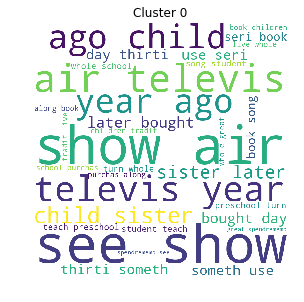

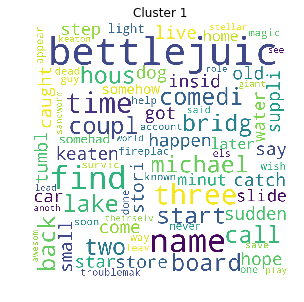

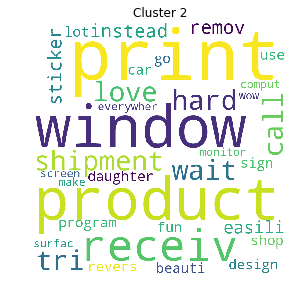

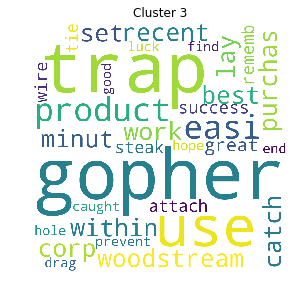

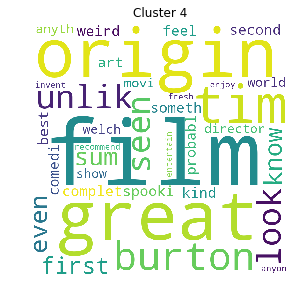

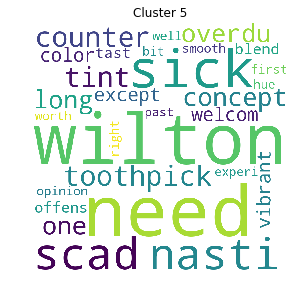

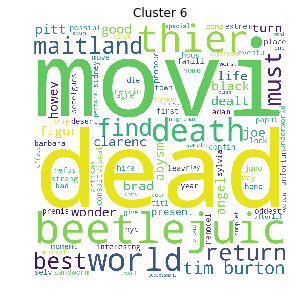

In [13]:
model = KMeans(n_clusters=7, random_state=42, verbose=0)
model.fit(svd_matrix)

cluster_sets = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_reviews = dict()
for i in cluster_sets:
    for j in cluster_sets[i]:
        cluster_reviews[i] = cluster_reviews.get(i, '') + data.iloc[i]['CleanedText']
        
for i in range(model.n_clusters):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(cluster_reviews[i])

    # plot the WordCloud image
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title(f'Cluster {i}')
    plt.tight_layout(pad = 0)

plt.show()

In [14]:
# Create a Data Frame out of 'svd_matrix' to simplify evaluations in the future
svd_df = pd.DataFrame(svd_matrix, index=co_matrix.index)
svd_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356
ironi,5.950558e-15,9.869988e-16,2.466024e-15,-1.220416e-14,-3.125606e-15,2.344030e-15,-4.895759e-16,1.608175e-14,1.012536e-15,2.256732e-09,...,1.408471e-16,9.743947e-17,-1.371373e-15,-8.292129e-17,2.486768e-15,-2.483553e-16,1.907956e-15,-1.805062e-12,3.209966e-16,-3.426618e-16
luau,-2.987546e-15,5.753540e-16,1.440840e-16,1.234644e-15,9.902358e-16,2.512576e-15,-1.667285e-15,1.215471e-15,-1.679755e-15,-2.506246e-16,...,2.656634e-17,-4.129504e-17,-1.521107e-16,-5.512363e-16,-2.217660e-16,-5.005909e-17,3.675752e-16,1.967703e-16,-9.692655e-17,-2.677372e-16
lucious,-3.333839e-15,3.466914e-15,5.987107e-15,-2.984638e-15,2.559941e-15,3.743227e-15,1.103758e-16,8.163563e-16,-2.774402e-15,-1.439218e-15,...,-3.821102e-16,1.420023e-16,5.793682e-19,-5.758074e-16,3.719887e-17,7.803245e-17,-3.048249e-16,-5.080518e-16,-6.316545e-16,-3.395080e-16
sprig,-4.973568e-16,9.559899e-17,6.532143e-16,8.674290e-16,-1.937960e-15,-1.452259e-15,2.974055e-15,-2.446069e-16,-1.270674e-15,-1.001432e-15,...,-6.982138e-17,2.667882e-17,1.534356e-16,-4.915017e-17,-3.065013e-16,2.461880e-18,3.746884e-16,1.262442e-16,4.577259e-16,8.817323e-17
springi,-1.744121e-15,-1.550606e-15,-3.646690e-16,3.476436e-15,-1.083237e-16,7.326742e-16,1.596249e-15,-4.390726e-15,2.954793e-16,5.378028e-15,...,3.285496e-16,-5.099429e-16,-8.581602e-16,9.122732e-16,1.486650e-15,-3.908927e-16,-8.038042e-16,6.861118e-16,-6.761090e-16,-8.982752e-17


In [15]:
# Create the Cosine Similarity matrix and store the vocab list
sim_matrix = pd.DataFrame(cosine_similarity(svd_df), index=co_matrix.index, columns=co_matrix.index)
vocab = list(sim_matrix.index)
sim_matrix.head()

,ironi,luau,lucious,sprig,springi,tabbouleh,sprint,panini,bionatur,discret,...,cautionari,fairi,shoyu,jiff,mtn,mucho,excruci,chime,caroten,raccoon
ironi,1.000000e+00,-3.120499e-16,0.034912,2.397735e-16,-0.029507,-2.961917e-17,0.012748,-9.523147e-16,0.009389,0.006789,...,-1.968728e-16,0.0,2.022857e-17,-2.080100e-16,-2.570677e-16,1.153772e-16,-3.602013e-16,0.0,3.445365e-16,1.250961e-15
luau,-3.120499e-16,1.000000e+00,0.055572,9.242910e-17,-0.053207,3.364592e-16,0.005074,3.122944e-16,0.026478,0.000598,...,1.301033e-16,0.0,5.802735e-16,-5.442348e-17,-1.192725e-15,1.838111e-16,-1.861035e-16,0.0,-9.331779e-17,-8.932597e-17
lucious,3.491220e-02,5.557229e-02,1.000000,1.019468e-02,-0.551968,1.931669e-02,0.464450,1.587035e-03,0.217148,0.429647,...,5.099587e-04,0.0,-3.298357e-03,1.283139e-02,-1.873940e-02,6.707532e-03,-2.843985e-02,0.0,6.120667e-03,-3.555034e-02
sprig,2.397735e-16,9.242910e-17,0.010195,1.000000e+00,0.000634,7.354447e-17,-0.010256,-4.486237e-16,-0.013753,-0.017167,...,3.401894e-16,0.0,-4.452102e-18,3.889479e-16,-7.995690e-17,1.744296e-17,3.264016e-17,0.0,4.089078e-16,1.042171e-16
springi,-2.950739e-02,-5.320682e-02,-0.551968,6.338733e-04,1.000000,4.974153e-03,-0.152782,6.660202e-03,-0.250343,-0.125122,...,-1.245485e-02,0.0,2.155994e-02,2.099026e-02,-6.680181e-03,-5.012784e-03,-4.764864e-02,0.0,-1.121511e-02,4.850633e-02


In [16]:
# Get Similar words based on an input query
def print_similar_words(query):
    print(f'Top 10 similar words to "{query}" :-\n')
    top_idx = np.argsort(sim_matrix[query].values)[1:11]
    [print(vocab[i], sim_matrix[query].iloc[i]) for i in top_idx]

print_similar_words('lucious')

Top 10 similar words to "lucious" :-

lollypop -0.2237279582295292
jigger -0.21276670757531996
heftier -0.1993450530577731
meyenberg -0.1924369812901954
deoder -0.17505057911773925
overreact -0.1706934867627062
pigeon -0.17047571191392644
sharki -0.15990248995846934
salsita -0.15790530623819468
whimsic -0.1536980746531176
